In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581825 (6).txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581651 (3).txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581831 (10).txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581834 (5).txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581660 (3).txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581659 (5).txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581832.txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581657.txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581833 (2).txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/1163464.txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581658 (4).txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581827 (7).txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581829 (7).txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581827 (1).txt
/kaggle/input/anotacoes/Anotacoes YOLO/val/labels/581661 (3).txt
/kaggle/input/anotacoes/Anotacoes Y

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-10.3.

In [3]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 20.1MB/s]


In [5]:
# Cria o YAML com os caminhos corretos
yaml_content = """
train: /kaggle/input/anotacoes/Anotacoes YOLO/train/images
val: /kaggle/input/anotacoes/Anotacoes YOLO/val/images
test: /kaggle/input/anotacoes/Anotacoes YOLO/test/images

nc: 3
names: ['watertank', 'pool', 'waste']
"""

# Salva o arquivo no diretório atual
with open("custom_data.yaml", "w") as f:
    f.write(yaml_content)


In [6]:
results = model.train(data="custom_data.yaml", epochs=50, imgsz=256)

Ultralytics 8.3.134 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=custom_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained

100%|██████████| 755k/755k [00:00<00:00, 4.13MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 19.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.1±0.2 ms, read: 31.7±10.4 MB/s, size: 131.6 KB)


train: Scanning /kaggle/input/anotacoes/Anotacoes YOLO/train/labels... 936 images, 0 backgrounds, 0 corrupt: 100%|██████████| 936/936 [00:02<00:00, 391.45it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/anotacoes/Anotacoes YOLO/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 26.2±9.4 MB/s, size: 138.1 KB)


val: Scanning /kaggle/input/anotacoes/Anotacoes YOLO/val/labels... 232 images, 0 backgrounds, 0 corrupt: 100%|██████████| 232/232 [00:00<00:00, 350.52it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/anotacoes/Anotacoes YOLO/val is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 256 train, 256 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.566G      1.658      2.947      1.208         20        256: 100%|██████████| 59/59 [00:06<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.33it/s]

                   all        232        514      0.937     0.0595      0.468      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      0.57G      1.563      1.658      1.147         14        256: 100%|██████████| 59/59 [00:05<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.07it/s]


                   all        232        514      0.592      0.287      0.438      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      0.57G      1.515      1.464      1.152         25        256: 100%|██████████| 59/59 [00:05<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.24it/s]

                   all        232        514      0.559      0.534      0.592      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      0.57G      1.542        1.4       1.15         22        256: 100%|██████████| 59/59 [00:05<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.54it/s]


                   all        232        514      0.574      0.724      0.597      0.349

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      0.57G      1.475      1.308      1.164         18        256: 100%|██████████| 59/59 [00:05<00:00, 11.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.00it/s]


                   all        232        514      0.638      0.635      0.632      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      0.57G      1.472       1.24      1.126         20        256: 100%|██████████| 59/59 [00:05<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

                   all        232        514       0.81      0.569      0.616      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      0.57G      1.415      1.177       1.13          8        256: 100%|██████████| 59/59 [00:05<00:00, 11.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.40it/s]


                   all        232        514      0.685      0.639      0.668      0.351

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      0.57G      1.442      1.167      1.122         15        256: 100%|██████████| 59/59 [00:05<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.44it/s]

                   all        232        514      0.697      0.679      0.681      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      0.57G      1.378      1.128      1.111         22        256: 100%|██████████| 59/59 [00:05<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.40it/s]


                   all        232        514      0.662      0.629      0.636      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      0.57G      1.377      1.093      1.091         29        256: 100%|██████████| 59/59 [00:05<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.11it/s]


                   all        232        514      0.612      0.681      0.674      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      0.57G      1.371      1.095      1.098          9        256: 100%|██████████| 59/59 [00:05<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]


                   all        232        514      0.697      0.701        0.7      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      0.57G      1.371      1.074      1.095         12        256: 100%|██████████| 59/59 [00:05<00:00, 11.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.13it/s]

                   all        232        514      0.675      0.623      0.658      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      0.57G      1.354      1.054      1.102         25        256: 100%|██████████| 59/59 [00:05<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.21it/s]

                   all        232        514      0.616      0.587      0.622      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      0.57G      1.363       1.03      1.103         21        256: 100%|██████████| 59/59 [00:05<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

                   all        232        514      0.531      0.667       0.65      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      0.57G      1.316      1.003      1.084         13        256: 100%|██████████| 59/59 [00:05<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.45it/s]

                   all        232        514      0.717      0.657      0.658      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      0.57G      1.302     0.9685      1.057         20        256: 100%|██████████| 59/59 [00:05<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.03it/s]


                   all        232        514      0.616      0.702      0.677      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      0.57G      1.307     0.9947      1.081         21        256: 100%|██████████| 59/59 [00:05<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.94it/s]


                   all        232        514      0.694      0.646      0.699      0.411

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      0.57G      1.298     0.9615      1.079         17        256: 100%|██████████| 59/59 [00:05<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.38it/s]

                   all        232        514      0.616      0.632      0.645      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      0.57G      1.292      0.961       1.06         12        256: 100%|██████████| 59/59 [00:05<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.88it/s]


                   all        232        514      0.661      0.609      0.635      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      0.57G      1.331     0.9909      1.098         17        256: 100%|██████████| 59/59 [00:05<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.03it/s]


                   all        232        514      0.663      0.669      0.686      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      0.57G      1.289     0.9641      1.067         26        256: 100%|██████████| 59/59 [00:05<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.14it/s]


                   all        232        514      0.686      0.614      0.658      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      0.57G      1.244     0.9122      1.041         19        256: 100%|██████████| 59/59 [00:05<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.92it/s]

                   all        232        514      0.621      0.694      0.654      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      0.57G      1.258     0.9201      1.057         26        256: 100%|██████████| 59/59 [00:05<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.71it/s]

                   all        232        514      0.678      0.702      0.708      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      0.57G      1.258      0.897      1.047         29        256: 100%|██████████| 59/59 [00:05<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.27it/s]

                   all        232        514      0.758      0.705      0.734      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      0.57G      1.259     0.9191      1.047         11        256: 100%|██████████| 59/59 [00:05<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.99it/s]

                   all        232        514      0.698      0.612      0.668       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      0.57G      1.209      0.857      1.032         22        256: 100%|██████████| 59/59 [00:05<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.49it/s]

                   all        232        514      0.714      0.621      0.715      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      0.57G      1.219     0.9033      1.047         27        256: 100%|██████████| 59/59 [00:05<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.57it/s]


                   all        232        514      0.723      0.668      0.705       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      0.57G      1.214     0.8832      1.053         26        256: 100%|██████████| 59/59 [00:05<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.68it/s]


                   all        232        514      0.715      0.631      0.673      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      0.57G      1.245     0.8971       1.06         25        256: 100%|██████████| 59/59 [00:05<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.95it/s]

                   all        232        514      0.726      0.663      0.726      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      0.57G      1.188     0.8732      1.051         23        256: 100%|██████████| 59/59 [00:05<00:00, 11.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.53it/s]

                   all        232        514      0.811      0.681      0.758      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      0.57G      1.201      0.883       1.05         15        256: 100%|██████████| 59/59 [00:05<00:00, 11.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]


                   all        232        514      0.761      0.675      0.741      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      0.57G      1.182     0.8376      1.029         20        256: 100%|██████████| 59/59 [00:05<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

                   all        232        514      0.669      0.696       0.73      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      0.57G      1.173     0.8206      1.024         13        256: 100%|██████████| 59/59 [00:05<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.42it/s]


                   all        232        514      0.726      0.744      0.742      0.413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      0.57G      1.192     0.8402      1.027         20        256: 100%|██████████| 59/59 [00:05<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.18it/s]


                   all        232        514       0.74      0.748      0.758      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      0.57G      1.193     0.8215      1.032         34        256: 100%|██████████| 59/59 [00:05<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]

                   all        232        514      0.782      0.677      0.751       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      0.57G      1.163     0.8085      1.024         19        256: 100%|██████████| 59/59 [00:05<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.77it/s]

                   all        232        514      0.706      0.753      0.742      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      0.57G      1.174     0.8118      1.018         21        256: 100%|██████████| 59/59 [00:05<00:00, 11.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.35it/s]

                   all        232        514      0.712      0.733      0.727      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      0.57G      1.117     0.7713      1.033         16        256: 100%|██████████| 59/59 [00:05<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.86it/s]

                   all        232        514      0.722      0.755      0.752      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      0.57G      1.117     0.7804          1         30        256: 100%|██████████| 59/59 [00:05<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.09it/s]

                   all        232        514      0.707      0.721      0.713      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      0.57G      1.177     0.7843      1.013         27        256: 100%|██████████| 59/59 [00:05<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.62it/s]

                   all        232        514      0.679      0.731      0.728      0.433


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      0.57G      1.131      0.763      1.017          8        256: 100%|██████████| 59/59 [00:05<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.72it/s]

                   all        232        514      0.749      0.676      0.724      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      0.57G      1.094     0.7639      1.012         15        256: 100%|██████████| 59/59 [00:05<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.20it/s]

                   all        232        514      0.704      0.762      0.728      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      0.57G      1.087     0.7412     0.9977         18        256: 100%|██████████| 59/59 [00:05<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.11it/s]

                   all        232        514      0.838      0.676      0.734      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      0.57G      1.072     0.7039     0.9911         11        256: 100%|██████████| 59/59 [00:05<00:00, 11.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.71it/s]

                   all        232        514      0.755      0.758       0.74      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      0.57G      1.085     0.7255      1.005         10        256: 100%|██████████| 59/59 [00:05<00:00, 11.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.63it/s]

                   all        232        514      0.772      0.741      0.761      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      0.57G      1.075     0.6963      1.001         13        256: 100%|██████████| 59/59 [00:05<00:00, 11.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.26it/s]


                   all        232        514      0.715      0.829      0.757      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      0.57G      1.065     0.6903     0.9843          8        256: 100%|██████████| 59/59 [00:05<00:00, 11.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

                   all        232        514      0.786      0.743      0.764      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      0.57G      1.046     0.6884     0.9787         12        256: 100%|██████████| 59/59 [00:05<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  7.62it/s]

                   all        232        514      0.735      0.778      0.751      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      0.57G      1.026     0.6741     0.9853          8        256: 100%|██████████| 59/59 [00:05<00:00, 11.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.81it/s]

                   all        232        514      0.811      0.652      0.743      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      0.57G      1.044     0.6718     0.9917         10        256: 100%|██████████| 59/59 [00:05<00:00, 11.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.40it/s]

                   all        232        514      0.725       0.72      0.753      0.444



50 epochs completed in 0.091 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.134 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.87it/s]


                   all        232        514      0.761      0.675      0.741      0.472
             watertank        167        370      0.941       0.69      0.893      0.525
                  pool         98        119      0.748      0.975      0.955      0.715
                 waste         16         25      0.594       0.36      0.375      0.177


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train


In [7]:
best_model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

In [8]:
from ultralytics import YOLO
from PIL import Image  # Importar PIL.Image para fromarray
import matplotlib.pyplot as plt


image 1/1 /kaggle/input/inferencia/1163373.png: 256x256 2 pools, 6.4ms
Speed: 0.6ms preprocess, 6.4ms inference, 1.6ms postprocess per image at shape (1, 3, 256, 256)


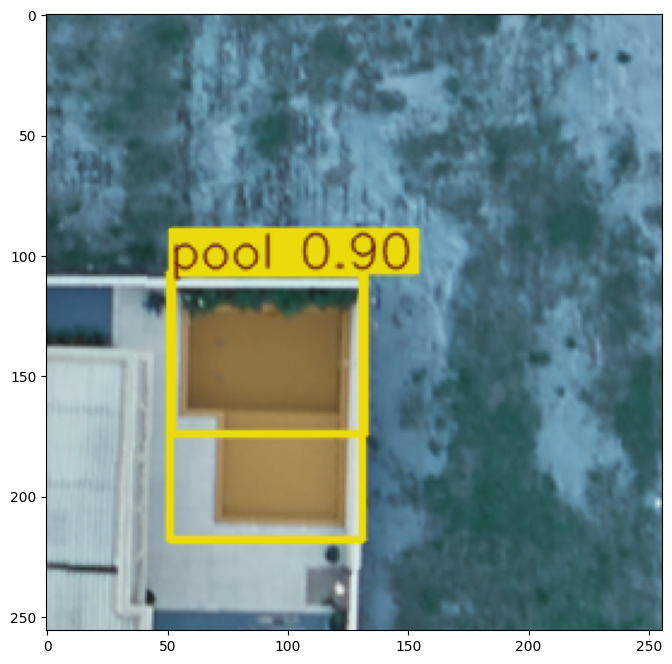

Imagem: /kaggle/input/inferencia/1163373.png



In [9]:
#image_paths = '/kaggle/input/inferencia/1163357.png'
image_paths = '/kaggle/input/inferencia/1163373.png' 
#image_paths = '/kaggle/input/inferencia/1163376.png'
#image_paths = "//kaggle/input/inferencia/1163631.png" #não detectada
#image_paths = '/kaggle/input/inferencia/1163683.png'


results = best_model.predict(image_paths, conf=0.5, imgsz=256)

annotated_img = results[0].plot()  # Caixas delimitadoras com array NumPy)
annotated_img_pil = Image.fromarray(annotated_img)  #PIL.Image.fromarray para transformar em img

plt.figure(figsize=(8, 8))
plt.imshow(annotated_img_pil)
plt.show()

print(f'Imagem: {image_paths}\n')

In [10]:
for i, result in enumerate(results[0].boxes):  # Itera sobre as caixas detectadas

    box_coords = result.xyxy[0].cpu().numpy()  # Converte para NumPy
    x_min, y_min, x_max, y_max = box_coords
    
    # Extrai a confiança como um valor escalar
    confidence = result.conf.cpu().numpy().item()  # Usa .item() para obter o valor escalar
    
    # Extrai o ID da classe como um valor escalar
    class_id = int(result.cls.cpu().numpy().item())  # Usa .item() para obter o valor escalar
    class_name = results[0].names[class_id]  # Nome da classe

    print(f'Objeto {i+1}:')
    print(f'  Classe: {class_name}')
    print(f'  Coordenadas (x_min, y_min, x_max, y_max): ({x_min:.2f}, {y_min:.2f}, {x_max:.2f}, {y_max:.2f})\n')

Objeto 1:
  Classe: pool
  Coordenadas (x_min, y_min, x_max, y_max): (51.83, 107.13, 131.47, 218.70)

Objeto 2:
  Classe: pool
  Coordenadas (x_min, y_min, x_max, y_max): (52.32, 107.86, 132.31, 174.66)



In [11]:
!pip install opencv-python

In [12]:
import cv2

In [13]:
image_paths = '/kaggle/input/inferencia/1163683.png'



image 1/1 /kaggle/input/inferencia/1163683.png: 256x256 2 watertanks, 1 pool, 8.8ms
Speed: 0.9ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 256, 256)


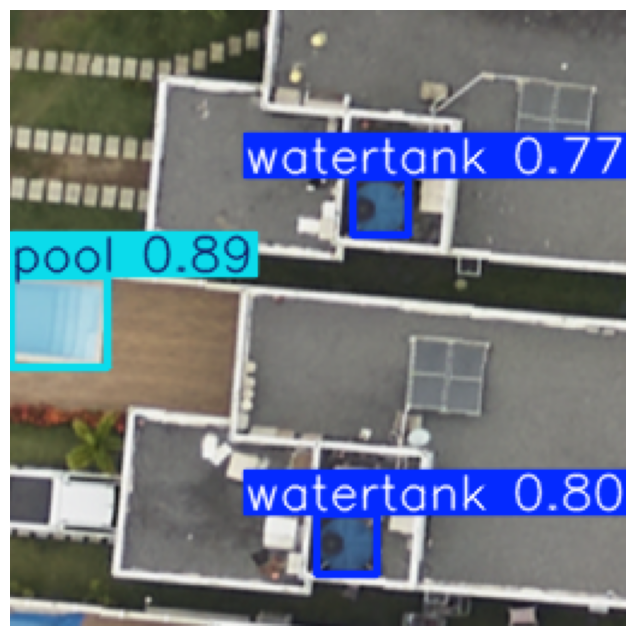

Objeto 1:
  Classe: pool
  Coordenadas (x_min, y_min, x_max, y_max): (0.17, 110.17, 40.81, 148.55)

Objeto 2:
  Classe: watertank
  Coordenadas (x_min, y_min, x_max, y_max): (127.82, 209.45, 152.42, 234.75)

Objeto 3:
  Classe: watertank
  Coordenadas (x_min, y_min, x_max, y_max): (142.79, 69.92, 165.52, 93.77)



In [14]:
# Realiza a predição
results = best_model.predict(image_paths, conf=0.5, imgsz=256)

# Obtém a imagem anotada com as caixas delimitadoras
annotated_img = results[0].plot()  # Caixas delimitadoras com array NumPy
annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)
annotated_img_pil = Image.fromarray(annotated_img_rgb)

# Exibe a imagem com as caixas delimitadoras
plt.figure(figsize=(8, 8))
plt.imshow(annotated_img_pil)
plt.axis('off') 
plt.show()

# Lista para armazenar os dados que serão salvos no CSV
data = []

# Extrai e imprime as coordenadas das caixas delimitadoras
for i, result in enumerate(results[0].boxes):  # Itera sobre as caixas detectadas
    box_coords = result.xyxy[0].cpu().numpy()  # Converte para NumPy
    x_min, y_min, x_max, y_max = box_coords
    
    # Extrai o ID da classe como um valor escalar
    class_id = int(result.cls.cpu().numpy().item())  # Usa .item() para obter o valor escalar
    class_name = results[0].names[class_id]  # Nome da classe

    # Imprime os resultados
    print(f'Objeto {i+1}:')
    print(f'  Classe: {class_name}')
    print(f'  Coordenadas (x_min, y_min, x_max, y_max): ({x_min:.2f}, {y_min:.2f}, {x_max:.2f}, {y_max:.2f})\n')

    # Adiciona os dados à lista
    data.append({
        'image_path': image_paths,
        'object_id': i + 1,
        'class': class_name,
        'x_min': x_min,
        'y_min': y_min,
        'x_max': x_max,
        'y_max': y_max
    })

# Cria um DataFrame com os dados
df = pd.DataFrame(data)

# Salva o DataFrame em um arquivo CSV no diretório /kaggle/working/
output_csv = '/kaggle/working/coordenadas.csv'
df.to_csv(output_csv, index=False)
